In [5]:
import lightgbm as lgb
from sklearn import metrics
import category_encoders as ce

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import xgboost as xgb

In [10]:
df = pd.read_csv('../data/train.csv',dtype={'tipodepropiedad':'category','ciudad':'category','provincia':'category'})
df['fecha'] = pd.to_datetime(df['fecha'])
df['anio'] = df['fecha'].dt.year
df["mes"] = df['fecha'].dt.month
df["dia"] = df['fecha'].dt.day


In [11]:
df = df.drop(columns=["lat","lng","direccion","id","descripcion","titulo"])

df1 = df#.drop(columns=["metrostotales"])
df1 = df1.dropna(subset=df1.columns)
df1.shape

(111519, 20)

In [12]:
def predecir(model, train_features, train_labels, test_features, test_labels):
    predict = model.score(test_features,test_labels)
    print('Entrenamiento: {:0.4f}%'.format(model.score(train_features, train_labels)*100))
    print('Testeo: {:0.4f}%.'.format(predict*100))
    
    return predict

In [13]:
from sklearn.preprocessing import LabelEncoder

cat_features = ['ciudad', 'provincia', 'tipodepropiedad']
data_cols = df._get_numeric_data().columns

baseline_data = df1[data_cols]

encoder = LabelEncoder()
encoded = df1[cat_features].apply(encoder.fit_transform)

data = baseline_data.join(encoded)

x = data[data.columns.drop("precio")]
y = data['precio']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.70)

In [14]:
rf = RandomForestRegressor(n_estimators = 800, min_samples_split = 3, min_samples_leaf = 2, max_features = 'log2', bootstrap = False)

In [15]:
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
                      max_features='log2', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=800,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [16]:
predecir(rf,x_train,y_train,x_test,y_test)

Entrenamiento: 97.8745%
Testeo: 78.9694%.


0.7896938259925427

<BarContainer object of 18 artists>

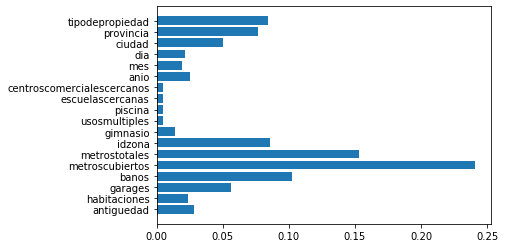

In [17]:
importancia = rf.feature_importances_
plt.barh(x.columns, rf.feature_importances_)

## Tunning RF

### Grid Search

In [2]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [3, 4, 5, None],
    'max_features': [2, 3, 'log2'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 4, 8, 10],
    'n_estimators': [800, 1000, 1300, 1500]
}

grid_search = GridSearchCV(estimator = rf,
                           param_grid = param_grid, 
                           cv = 3, 
                           n_jobs = -1,
                           verbose = 2)

NameError: name 'GridSearchCV' is not defined

In [ ]:
grid_search.fit(x_train, y_train)

In [ ]:
grid_search.best_params_
rf_grid = grid_search.best_estimator_

### Random Search

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'log2']
# Maximum number of levels in tree
max_depth = [2,3,4, None]
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
rf = RandomForestRegressor()
random_search = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 50, 
                               cv = 5,
                               n_jobs = -1,
                               verbose=2)

random_search.fit(x_train, y_train)

In [ ]:
rf_random = random_search.best_estimator_

In [ ]:
predecir(rf_grid,x_train,y_train,x_test,y_test)

In [ ]:
predecir(rf_random,x_train,y_train,x_test,y_test)